## A demo for endmember selection with PaCMAP and unmixing on a single tile - including preprocessing

In [12]:
# import modules
import sys
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
from functions_EDX import *

from VCA import *
import pacmap
from annoy import AnnoyIndex
import random
from ipywidgets import interact, widgets, Button, Output
import distinctipy

### load a single tile hyperspectral dataset

In [2]:
# choose a directory (from the multi-tile map)
npz_dir = '/Volumes/Microscopy3/EDX_data/old_datasets/NPZ/'
# or 'path/to/NPZdirectory' 
file_names = os.listdir(npz_dir)
file_names = [name for name in file_names if name.endswith('npz')]

# chooe the index of the dataset within the directory
file_idx = 9

# load data
file_path = os.path.join(npz_dir,file_names[file_idx])
loaded_file = np.load(file_path)
haadf = loaded_file['haadf']
spectrum = loaded_file['spectrum'][:,:,96:]
xray_energies = loaded_file['xray_energies'][96:]
size_xy = spectrum.shape[2]

### Pre-processing

In [3]:
# Binning in the spectral dimension
n_bins = 250
start = datetime.now()
spectrum = rebin_spectrum(spectrum,n_bins)
xray_energies = rebin_energies(xray_energies,n_bins)

# Binning in spatial dimensions
size_xy = 1024
spectrum = rebin_spectrumXY(spectrum,size_xy)  
haadf = rebin_XY(haadf,size_xy)       

# check if there are empty channels
where_notempty = ~np.all(spectrum==0,axis=(0,1))
spectrum = spectrum[:,:,where_notempty]
spectral_depth = spectrum.shape[2]
spectrum_2D = np.reshape(spectrum,(size_xy*size_xy,spectral_depth))
print("%04d channels remain" % spectral_depth)

# Mean-filter
spectrum = MeanFilterCube(spectrum.astype('float32'),sigma=2, size=3)
spectrum_2D = np.reshape(spectrum,(size_xy*size_xy,spectral_depth))

# Poisson scaling (i.e. weighted PCA)
g = np.mean(spectrum,axis=2).reshape(size_xy*size_xy,1)
h = np.mean(np.mean(spectrum,axis=0),axis=0).reshape(spectral_depth,-1)
W = g@np.transpose(h)
W = np.sqrt(W) 
spectrum_2D = np.divide(spectrum_2D,W)
spectrum = np.reshape(spectrum_2D,(size_xy,size_xy,spectral_depth))
end = datetime.now()
print('Preprocessing completed in {}'.format(end - start))

0250 channels remain
Preprocessing completed in 0:00:15.384280


### Display HAADF and NPS based on pre-processed data

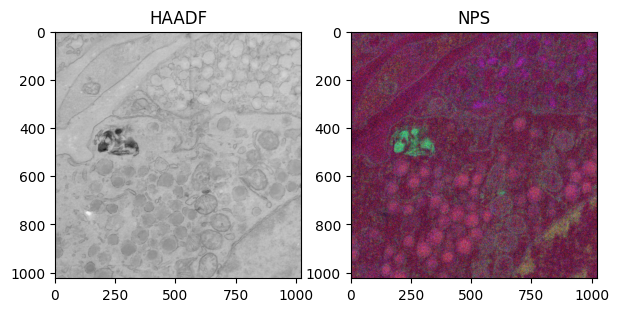

In [4]:
rgb = cv.merge([normalize8(spectrum[:,:,4]), normalize8(spectrum[:,:,25]), normalize8(spectrum[:,:,28])])
f, ax = plt.subplots(1,2,figsize=(7,5))
ax[0].imshow(haadf,cmap='gray_r')
ax[0].set_title('HAADF')
ax[1].imshow(rgb)
ax[1].set_title('NPS')
plt.show()

### Compute the extended spectrum: Gaussian Kernels with different radii around each pixel appended to the base specrum of the pixel.

In [5]:
# specify the desired radii for the kernels
radii = [1,3,5]
spectrum_ext = spectrum_plus(spectrum,radii=radii,sigma=2)
spectrum_2D_ext = np.dstack((spectrum,spectrum_ext)).reshape((-1,(len(radii)+1)*n_bins))
print(spectrum_2D_ext.shape)

(1048576, 1000)


### Overlap exclusion
- For multi-tile (mosaic) acquisitions, we exclude the overlapped area from the EDX analysis, as it is imaged twice. The function (overlap_corr) takes the index of the tile as input. If the dataset is not from a tiled acquisition, set the tile_idx as 0.

In [6]:
#  Overlap mask
overlap_mask = overlap_corr(tile_idx=0,xy_dim=size_xy,rows=6,cols=5,overlap_ratio=0.15).ravel()
non_overlap_indices = np.asarray([i for i in range(spectrum_2D.shape[0])])[~overlap_mask]

### Train PaCMAP and visualize the reduced dimensions

In [7]:
# configure PaCMAP
PACMAP_dist = 'euclidean'
MN_ratio = 0.5          #default 0.5
FP_ratio = 2.0          #default 2.0
    

# subsampling and other settings
extended = True                                 # use the extended (Gaussian kernel) spectra
p = None                        
subsample_ratio = 0.3
nTrain = int(subsample_ratio*size_xy**2)   # number of training samples


# random seed
random.seed(100)
n_sample_train = np.random.choice(non_overlap_indices,nTrain,p=p,replace=True)  

# PaCMAP
start = datetime.now()
reduction_model = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=MN_ratio, FP_ratio=FP_ratio,distance=PACMAP_dist,save_tree = True)


# set the effective spectrum for embedding
if extended:
    spectrum_2D_eff = spectrum_2D_ext
else:
    spectrum_2D_eff = spectrum_2D

# train model
reduction_model.fit(spectrum_2D_eff[n_sample_train,:])
embeddings = reduction_model.embedding_


# scaling (scaled both reduced dimensions to 0-1)
scaler = MinMaxScaler()
embeddings = scaler.fit_transform(embeddings)

# elapsed time
end = datetime.now()
etime = end-start
print('Duration for training PaCMAP is: {}'.format(end - start))

Duration for training PaCMAP is: 0:03:38.724272


### Visualize the reduced dimensions

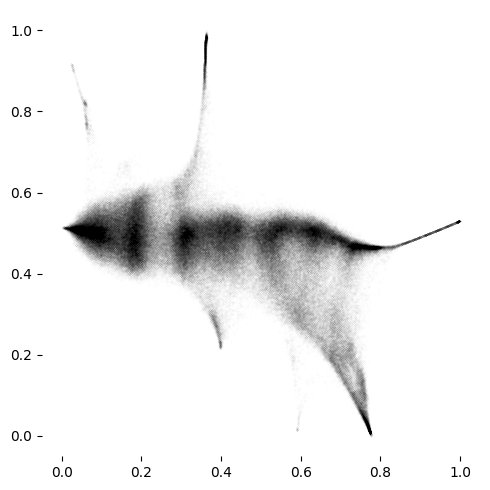

In [8]:
%matplotlib inline 
f, ax = plt.subplots(figsize=(5,5))
sns.despine(left=True, bottom=True, right=True)
ax.set_facecolor((1, 1, 1)) 
ax.scatter(embeddings[:,0],embeddings[:,1], s=0.0001,c='k') 
f.tight_layout()
#plt.axis('off')
plt.show()

### Widget for selecting the peaks

In [9]:
# choose a grid size
Grid = 256
xmin, xmax = np.amin(embeddings[:,0]), np.amax(embeddings[:,0])
ymin, ymax = np.amin(embeddings[:,1]), np.amax(embeddings[:,1])
counts, xedges, yedges = np.histogram2d(embeddings[:,0], embeddings[:,1], bins=Grid)

# initialize local maxima
local_maxi = []

# Widget
out = Output()
def on_button_click(b):
    with out:
        xloc = xloc_slider.value
        yloc = yloc_slider.value
        local_maxi.append((yloc, xloc))
        print(f"yloc: {yloc}, xloc: {xloc}, count: {str(counts[yloc][xloc])}")

def on_output_button_click(b):
    with out:
        print("local_maxi:", local_maxi)

def manual_peaks(xloc, yloc, width): 
    fig, ax = plt.subplots(1, 3, figsize=(15, 10))
    sns.despine(left=True, bottom=True, right=True)

    # 2D histogram density plot
    ax[0].set_title(str(counts[yloc][xloc]), size=10)
    ax[0].imshow(counts, cmap='jet',vmin=counts.min(),vmax=counts.max())
    ax[0].plot(xloc, yloc, 'wo', markersize=10)

    # the zoom
    ax[1].imshow(counts[yloc-width:yloc+width, xloc-width:xloc+width], cmap='jet') #,vmin=counts.min(),vmax=counts.max()) 
    ax[1].plot(width, width, 'wo', markersize=10)
    ax[1].set_title(str(counts[yloc][xloc]), size=10)

    # reference
    ax[2].scatter(embeddings[:,0],embeddings[:,1], s=0.00001,c='k') 
    ax[2].set_title('use as reference')
    ax[2].set_aspect('equal')
    
# Create sliders
xloc_slider = widgets.IntSlider(value=int(Grid/2), min=0, max=Grid, step=1)
yloc_slider = widgets.IntSlider(value=int(Grid/2), min=0, max=Grid, step=1)
width_slider = widgets.IntSlider(value=50, min=1, max=100, step=1, description='Zoom')

# Create buttons
print_button = Button(description='Save current peak')
print_button.on_click(on_button_click)

output_button = Button(description='Save and exit')
output_button.on_click(on_output_button_click)

# Display widgets and output
interact(manual_peaks, yloc=yloc_slider, xloc=xloc_slider, width=width_slider)
widgets.HBox([print_button, output_button, out])

interactive(children=(IntSlider(value=128, description='xloc', max=256), IntSlider(value=128, description='ylo…

### Run the cell below after selecting peaks with the widget

In [10]:
local_max_x = []
local_max_y = []

for i in range(0,len(local_maxi)):
    NewValue_X = (((local_maxi[i][0] ) * (xmax - xmin)) / (Grid - 0)) + xmin
    NewValue_Y = (((local_maxi[i][1] - 0) * (ymax - ymin)) / (Grid - 0)) + ymin
    local_max_x.append(NewValue_X)
    local_max_y.append(NewValue_Y)

x = [x for x in zip(local_max_x,local_max_y)]
nEM = len(x)
print("Number of endmembers selected %03d" % nEM)

Number of endmembers selected 006


### Visualize the pixels that represent the selected peaks (and endmembers)

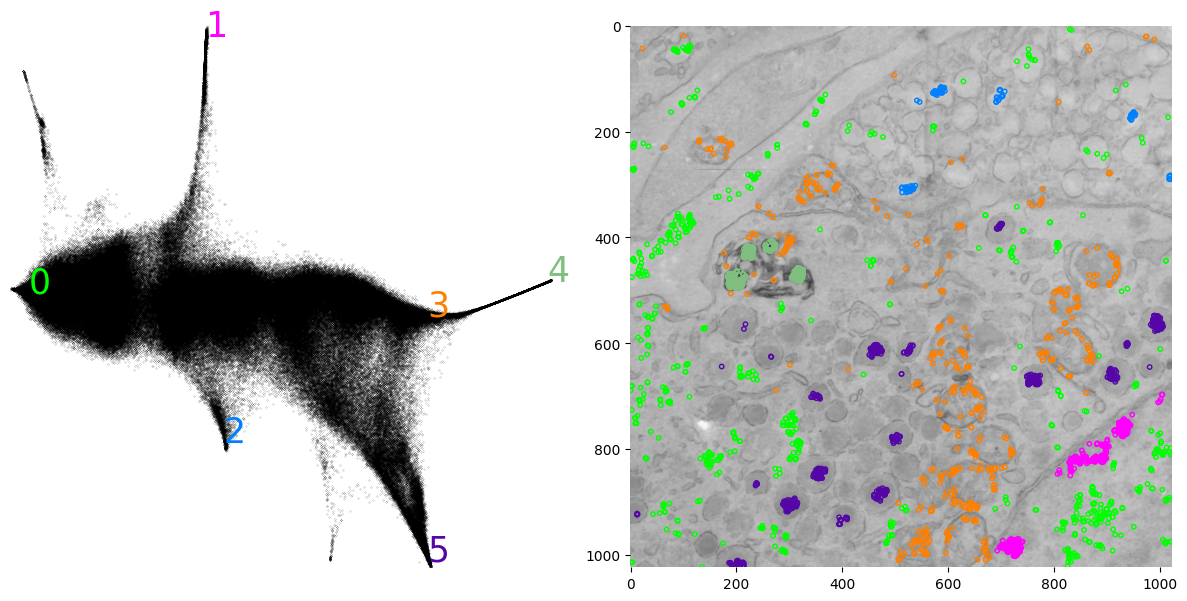

In [14]:
min_max = 1*(1/Grid) # determines bounding box size
points = len(x)
centroid = [] 
F = []           

for i in range(0,points):
    #set bounding square 
    Minx = x[i][0] - min_max
    Maxx = x[i][0] + min_max
    Miny = x[i][1] - min_max
    Maxy = x[i][1] + min_max
    
    #select points
    z3 = [0 if j == 0 else j for j in [j if j <= Maxx else 0 for j in [j if j >= Minx else 0 for j in embeddings[:,0]]]]
    zz3 = [0 if j == 0 else j for j in [j if j <= Maxy else 0 for j in [j if j >= Miny else 0 for j in embeddings[:,1]]]]
    f = [i for i, e in enumerate([x*y for x,y in zip(z3,zz3)]) if e != 0]
    d = embeddings[f]
    F.append(f)
    centroid.append(d)
    
%matplotlib inline 
fig, ax = plt.subplots(1,2,figsize=(12,12))
sns.despine(left=True, bottom=True, right=True)

# Scatter plot of the embeddings
ax[0].scatter(embeddings[:,0],embeddings[:,1],c='k',s=0.01, alpha=1)
ax[0].set_ylim([ymin, ymax])
ax[0].set_xlim([xmin, xmax])
ax[0].axes.get_xaxis().set_visible(False)
ax[0].axes.get_yaxis().set_visible(False)
ax[0].set_aspect('equal')


# Plot pixels used to select endmembers
for i in range(0,len(x)):
    ax[0].scatter(centroid[i].transpose()[0], centroid[i].transpose()[1], color='red', s=0.00001, alpha = 0.001)


colors = distinctipy.get_colors(len(x))

# Endmember annotation
label = [val for val in list(range(len(x)))]
centroids = np.array(x).transpose()
    
for i, txt in enumerate(label):
    ax[0].annotate(txt, (centroids[0][i], centroids[1][i]), color=colors[i], size=25)  


ax[1].imshow(haadf,cmap='gray_r')

for i in range(len(x)):
    yy = n_sample_train[F[i]] 
    xx = np.arange(1024**2).reshape((1024,1024))
    zz = [np.where(xx==j) for j in yy]
    k = [ii[0] for ii in zz]
    kk = [ii[1] for ii in zz]
    ax[1].scatter(kk,k,s=10,facecolor='none', edgecolor=colors[i])

#ax[1].legend()
fig.tight_layout()
plt.show()


### Compute endmember based on the selected regions

Text(0, 0.5, 'Counts (a.u.)')

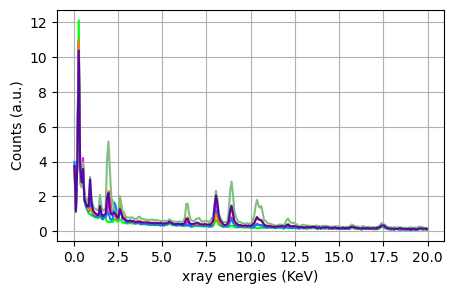

In [21]:
end_members = []
for i in range(0, len(x)):
    jj = np.mean(spectrum_2D[n_sample_train][F[i]], axis = 0)
    end_members.append(jj)
end_members = np.array(end_members).transpose()

f, ax = plt.subplots(figsize=(5,3))
for i in range(end_members.shape[1]):
    ax.plot(xray_energies,end_members[:,i],c=colors[i])
plt.grid(True)
ax.set_xlabel('xray energies (KeV)')
ax.set_ylabel('Counts (a.u.)')

### Compute abundances using non-negative least squares

In [22]:
Ends = np.array([nnls(end_members,i)[0] for i in spectrum_2D]).transpose()
print('Done')

Done


### Display the abundance maps

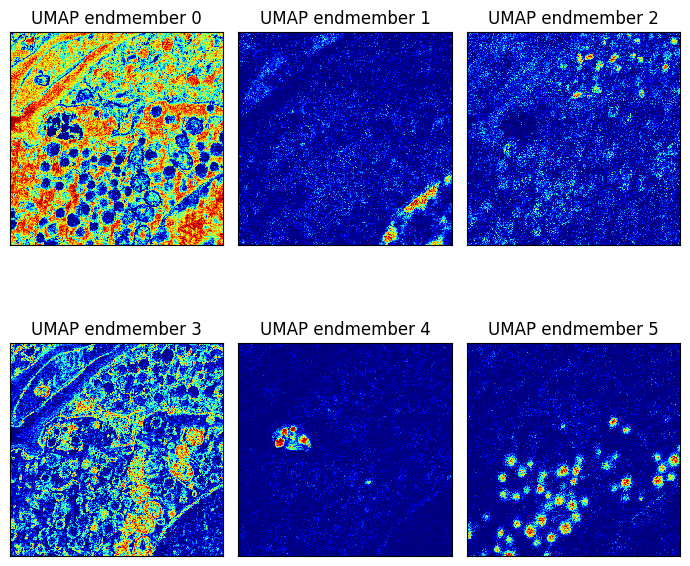

In [24]:
End_maps = np.reshape(Ends,(np.shape(Ends)[0],size_xy,size_xy))
%matplotlib inline 
cmap = 'jet'

# set layout
rows = 2
cols = 3

fig, ax = plt.subplots(rows,cols,figsize=(7,7))
em_idx = 0
for i in range(rows):
    for j in range(cols):
        try:
            ax[i][j].imshow(End_maps[em_idx]*~overlap_corr(tile_idx=0,xy_dim=size_xy,rows=rows,cols=cols,overlap_ratio=0.20), interpolation='nearest',cmap=cmap, vmin = 0)
        except:
            ax[i][j].imshow(np.zeros((1024,1024)), interpolation='nearest',cmap=cmap, vmin = 0)
        ax[i][j].set_title('UMAP endmember ' + str(em_idx))
        ax[i][j].axes.get_xaxis().set_visible(False)
        ax[i][j].axes.get_yaxis().set_visible(False)
    
        em_idx+=1
fig.tight_layout()    
plt.show()

## The overall abundane array (used later on)
abundance_map = np.max(End_maps,axis=0)


### Pre-copmute a colored composite image of the abundance maps 
- This is used in the interactive widgets at the end of this notebook

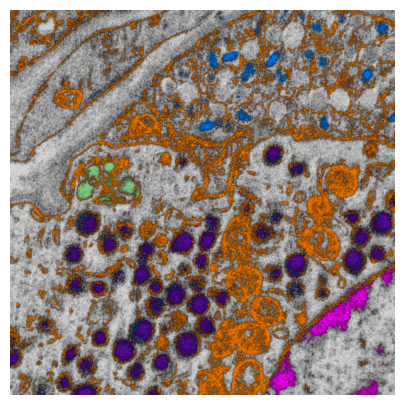

In [25]:
paint_idx = [i for i in range(end_members.shape[1])]  # user could exclude 
abundance_maps_selected = End_maps[paint_idx,:,:]
rgb_abundance = np.zeros((3,1024,1024))

# choose random colors
colors = distinctipy.get_colors(end_members.shape[1])

# optional set one of the colors to white/gray or black
colors[0] = [211/255,211/255,211/255]
#colors[0] = [0,0,0]


for x in range(rgb_abundance.shape[1]):
    for y in range(rgb_abundance.shape[2]):
        idx = np.argmax(abundance_maps_selected[:,x,y])
        rgb_abundance[0,x,y] = colors[idx][0] * abundance_maps_selected[idx,x,y]
        rgb_abundance[1,x,y] = colors[idx][1] * abundance_maps_selected[idx,x,y]
        rgb_abundance[2,x,y] = colors[idx][2] * abundance_maps_selected[idx,x,y]
rgb_abundance = (np.copy(rgb_abundance[:,:,:]).transpose(1,2,0)*255).astype('uint8')

# display
fig,ax = plt.subplots(figsize=(5,5))
ax.set_axis_off()
ax.set_frame_on('False')

# 3D equivalent to the overlap exclusion
overlap_mask_3d = np.repeat(~overlap_corr(tile_idx=file_idx,xy_dim=1024,rows=rows,cols=cols,overlap_ratio=0.17)[:, :, np.newaxis], 3, axis=2)
ax.imshow(rgb_abundance*overlap_mask_3d)


### Precompute reconstruction of the specrtral dataset based on the endmembers and abundance, and compute the error
- This is also used in the widget at the end of the notebook

In [26]:
recon_spectrum = np.dot(end_members,End_maps[:,:,:].reshape((-1,1024**2)))

# the mask in 2D
mask_show = ~overlap_corr(tile_idx=0,xy_dim=1024,rows=rows,cols=cols,overlap_ratio=0.15)

# Reconstruction error
SE_spectrum = np.square(spectrum_2D - recon_spectrum.transpose())
MSE = np.mean(SE_spectrum)
RMSE = np.sqrt(MSE)

# the mean SE per pixel
SE_spectrum_pp = SE_spectrum.mean(axis=1).reshape((size_xy,size_xy))

## Annoy for nearest neighbor caculations 
- Used in the interactive widget

In [28]:
f =  end_members.shape[1]   
AnnoyInstance = AnnoyIndex(f, 'euclidean')
tmp = Ends.transpose()   

start = datetime.now()
for i in range(spectrum_2D.shape[0]):
    v = tmp[i]
    AnnoyInstance.add_item(i, v)
print('Time to add items: {}'.format(datetime.now() - start))

start = datetime.now()
AnnoyInstance.build(20) # 10 trees
print('Time to build the annoy tree: {}'.format(datetime.now() - start))
#del tmp

Time to add items: 0:00:00.462254
Time to build the annoy tree: 0:00:06.689292


## Interactive analysis widget (pre-compute the required data first!)

In [29]:
%matplotlib inline


def plot(xloc,yloc,width,displaycolor,markercolor,showendmember,showrecon,showNN,K,nn_markerSize):
    # number of endmembers
    nEM = End_maps.shape[0]

    # start figure
    fig = plt.figure(layout="constrained",figsize=(10,5)) #plt.subplots(2,3,figsize=(15,15))
    gs = GridSpec(2, 3, figure=fig)
    

    ax1 = fig.add_subplot(gs[0,0])   # UMAP
    ax2 = fig.add_subplot(gs[0,1])   # Sample
    ax3 = fig.add_subplot(gs[0,2])    # Zoom
    ax4 = fig.add_subplot(gs[1,:2])   # Spectra
    ax5 = fig.add_subplot(gs[1,2])    # abundance bars

    
    
    if displaycolor == 'ABUNDANCE':
        ax1.scatter(embeddings[:,0],embeddings[:,1],c=abundance_map.reshape(1024**2)[n_sample_train],cmap='jet',s=0.01, alpha=1)
    elif displaycolor == 'HAADF':
        ax1.scatter(embeddings[:,0],embeddings[:,1],c='k',s=0.01, alpha=0.1)
    elif displaycolor == 'NPS':
        ax1.scatter(embeddings[:,0],embeddings[:,1],c=rgb.reshape(1024**2,3)[n_sample_train,:]/255,s=0.01, alpha=1)
    elif displaycolor == 'ABUNDANCE CLR':
        ax1.scatter(embeddings[:,0],embeddings[:,1],c=rgb_abundance.reshape(1024**2,3)[n_sample_train]/255,s=0.01)# alpha=1)
    elif displaycolor == 'SqrError':
        ax1.scatter(embeddings[:,0],embeddings[:,1],c = SE_spectrum_pp.reshape(1024**2)[n_sample_train],cmap='jet',s=0.01, alpha=1)
        
    
    ax1.set_ylim([ymin, ymax])
    ax1.set_xlim([xmin, xmax])
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    ax1.set_aspect('equal')

    
    # Annotate the endmember centroids
    for i, txt in enumerate(label):
        ax1.annotate(txt, (centroids[0][i], centroids[1][i]), color=colors[i], size=10)  
    
    
    # find a point on the HAADF and UMAP
    xx = np.arange(1024**2).reshape((1024,1024))[yloc,xloc]
    yy = spectrum_2D_eff[xx,:].reshape(-1,spectrum_2D_eff.shape[1])

    # PCAMAP requires the data you fitted with to transform a new dataset or point
    zz = scaler.transform(reduction_model.transform(yy))

    
    if displaycolor == 'NPS':
        ax2.imshow(overlap_mask_3d*rgb)
        ax2.set_title('NPS')
        ax3.imshow(rgb[yloc-width:yloc+width,xloc-width:xloc+width,:])
    elif displaycolor == 'HAADF':
        ax2.imshow(mask_show*haadf,cmap='gray_r')
        ax2.set_title('HAADF')
        ax3.imshow(haadf[yloc-width:yloc+width,xloc-width:xloc+width],cmap='gray_r')
    elif displaycolor == 'ABUNDANCE':
        ax2.imshow(mask_show*abundance_map,cmap='jet')
        ax2.set_title('MAX ABUNDANCE')
        ax3.imshow(abundance_map[yloc-width:yloc+width,xloc-width:xloc+width],cmap='jet')
    elif displaycolor == 'ABUNDANCE CLR':
        ax2.imshow(overlap_mask_3d*rgb_abundance)
        ax2.set_title('ABUNDANCE CLR')
        ax3.imshow(rgb_abundance[yloc-width:yloc+width,xloc-width:xloc+width])
    elif displaycolor == 'SqrError':
        ax2.imshow(mask_show*SE_spectrum_pp)
        ax2.set_title('Squared error per pixel')
        ax3.imshow(SE_spectrum_pp[yloc-width:yloc+width,xloc-width:xloc+width])
    

    # the marker
    ax2.plot(xloc,yloc,c=markercolor,marker='o')
    ax1.plot(zz[:,0],zz[:,1],c=markercolor,marker='o')
    ax3.plot(width,width,c=markercolor,marker='o')

    # clean up
    sns.despine(ax=ax1,top=True, right=True, left=True, bottom=True)
    sns.despine(ax=ax4,top=True, right=True, left=False, bottom=False)
    #sns.despine(ax=ax5,top=True, right=False, left=False, bottom=False)
    ax3.axes.get_xaxis().set_visible(False)
    ax3.axes.get_yaxis().set_visible(False)
    ax3.set_title('Zoom in')


    # spectra
    ax4.plot(xray_energies,spectrum_2D[xx,:]-spectrum_2D.mean(axis=0),c='k')
    ax4.set_ylim([-1,2])
    ax4.set_xlabel('KeV'); ax4.set_ylabel('mean-centered');
    ax4.axes.get_xaxis().set_visible(True); ax4.axes.get_yaxis().set_visible(True)
    
    if showendmember:
        ax4.plot(xray_energies,end_members[:,np.argmax(End_maps[:,yloc,xloc])]-spectrum_2D.mean(axis=0),'r-.')
    if showrecon:
        recon =  recon_spectrum[:,xx]   #np.dot(end_members,End_maps[:,yloc,xloc])
        ax4.plot(xray_energies,recon-spectrum_2D.mean(axis=0),'g-.')
        MSE = np.mean((spectrum_2D[xx,:]-recon)**2)
        ax4.text(12,1,str('MSE = %.04f' % MSE), fontsize=10,bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))

    # abundance bar plot
    ax5.bar(range(nEM),End_maps[:,yloc,xloc],color=colors)
    ax5.set_xlabel('endmember'); ax5.set_ylabel('abundance');
    ax5.set_xlim([-1,nEM]); ax5.set_ylim([0,1])
    ax5.set_xticks(range(nEM))
    ax5.set_xticklabels([str(i) for i in range(nEM)])
    ax5.grid('True')

    #plt.tight_layout()

    if showNN:
        nn_index,nn_distances = AnnoyInstance.get_nns_by_item(xx, K,include_distances=True)
        #print(xx)
        #print(tmp[xx])
        #print(nn_index)
        #print(nn_distances)
        #print(tmp[nn_index])
        for idx in nn_index:
            xxx,yyy = np.unravel_index(idx, (1024,1024), order='C')
            ax2.plot(yyy,xxx,c='w',marker='o',markersize=nn_markerSize)

interact(plot, 
        xloc = widgets.IntSlider(value=201, min=0, max=1023, step=1),
        yloc = widgets.IntSlider(value=491, min=0, max=1023, step=1),
        width=widgets.IntSlider(value=50, min=1, max=100, step=1,discription='Zoom'),
        #RGB = widgets.ToggleButton(value=False,description='RGB',disabled=False))
        displaycolor = widgets.ToggleButtons(options=['HAADF','NPS','ABUNDANCE','ABUNDANCE CLR','SqrError'],description='Display:',disabled=False),
        markercolor = widgets.ToggleButtons(options=['red','yellow','white'],description='Marker:',disabled=False),
        showendmember = widgets.Checkbox(value=False,description='Show most abundant endmember',disabled=False,indent=False),
        showrecon = widgets.Checkbox(value=False,description='Show reconstruction',disabled=False,indent=False),
        showNN = widgets.Checkbox(value=False,description='Show nearest neighbors',disabled=False,indent=False),
        K = widgets.IntSlider(value=1, min=1, max=50000, step=1),
        nn_markerSize = widgets.FloatSlider(value=1, min=0.05, max=1, step=0.05));

interactive(children=(IntSlider(value=201, description='xloc', max=1023), IntSlider(value=491, description='yl…